# Library Import

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('punkt_tab')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Import data

In [2]:
data = pd.read_csv("spam.csv",encoding='latin1')
data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3347,ham,"Sorry, I'll call later",NaN,NaN,NaN
507,ham,You should know now. So how's anthony. Are you...,NaN,NaN,NaN
539,ham,"I am in tirupur da, once you started from offi...",NaN,NaN,NaN
1271,ham,If you still havent collected the dough pls le...,NaN,NaN,NaN
3461,spam,Bloomberg -Message center +447797706009 Why wa...,NaN,NaN,NaN


# Drop unwanted columns

In [3]:
data.drop(columns = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"], inplace = True)
data.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Rename columns

In [4]:
data.rename(columns = {"v1":'result', 'v2':'emails'}, inplace = True)

# Returns number of NaN values in columns

In [5]:
data.isnull().sum()

result    0
emails    0
dtype: int64

# Returns number of duplicates

In [6]:
data.duplicated().sum()

403

# Drops duplicates keeping first occurences

In [7]:
data = data.drop_duplicates(keep='first')

In [8]:
data.shape

(5169, 2)

In [9]:
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Number of spam/ham emails

In [10]:
data['result'].value_counts()

result
ham     4516
spam     653
Name: count, dtype: int64

# Pie-chart

([<matplotlib.patches.Wedge at 0x1d997d18d60>,
 [Text(-1.0144997251399075, 0.4251944351600247, 'ham'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001344, '87.4%'),
  Text(0.5533635081542612, -0.23192418555038377, '12.6%')])

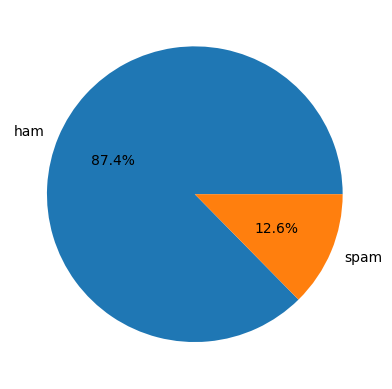

In [18]:
plt.pie(data['result'].value_counts(),labels = data['result'].value_counts().index, autopct='%1.1f%%')

# EDA (email length, no. of words, sentences, Bar-graph)

In [15]:
data['Length'] = data['emails'].apply(len)
data['num_words'] = data['emails'].apply(word_tokenize).apply(len)
data['num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)
data.head(2)

,result,emails,Length,num_words,num_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2


In [16]:
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()

Average Length of Spam Emails: 137.89127105666157
Average Length of Ham Emails: 70.45925597874225


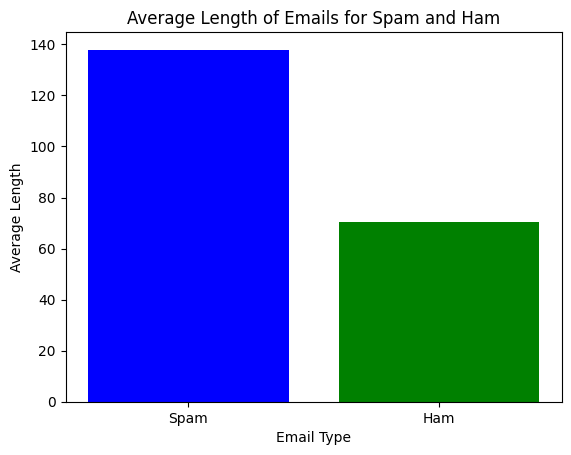

In [17]:
#plotting
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham)
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()